In [13]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
# Load data
data = pd.read_csv('transaction_dataset.csv')  # Update the path accordingly

data = data.dropna()

# Assuming 'features' are the input features and 'label' is the target variable
X = data.drop('FLAG', axis=1)  # Update 'FLAG' to your target column name if different
y = data['FLAG']  # Update 'FLAG' to your target column name if different

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X = preprocessor.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class DeepResidualANNModel(nn.Module):
    def __init__(self):
        super(DeepResidualANNModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)  # Layer for residual connection
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)    # Layer for residual connection
        self.fc6 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, 2)  # Assuming binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # First residual connection
        x_residual1 = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x_residual1)) + x_residual1  # Adding residual connection
        
        x = F.relu(self.fc4(x))
        
        # Second residual connection
        x_residual2 = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x_residual2)) + x_residual2  # Adding residual connection
        
        x = self.fc_out(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = DeepResidualANNModel()


In [5]:
import random

def genetic_algorithm():
    # Define GA parameters
    population_size = 10
    generations = 5
    mutation_rate = 0.1

    # Initialize population with random hyperparameters
    population = [{'lr': random.uniform(0.001, 0.01), 'batch_size': random.choice([16, 32, 64])} for _ in range(population_size)]

    def fitness(individual):
        # Train the model with given hyperparameters and return validation accuracy
        lr = individual['lr']
        batch_size = individual['batch_size']
        
        # Create new data loader with batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Train the model (simplified training loop)
        model.train()
        for epoch in range(3):  # Limited epochs for GA optimization
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = F.nll_loss(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # Evaluate the model on validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        return accuracy

    print(generations)
    for generation in range(generations):
        print(generation)
        # Evaluate fitness of population
        fitness_scores = [fitness(individual) for individual in population]

        # Select individuals for mating
        selected_individuals = random.choices(population, weights=fitness_scores, k=population_size)

        # Create new population through crossover and mutation
        new_population = []
        for i in range(population_size // 2):
            parent1 = selected_individuals[i]
            parent2 = selected_individuals[population_size - i - 1]
            # Crossover
            child1 = {'lr': parent1['lr'], 'batch_size': parent2['batch_size']}
            child2 = {'lr': parent2['lr'], 'batch_size': parent1['batch_size']}
            # Mutation
            if random.random() < mutation_rate:
                child1['lr'] = random.uniform(0.001, 0.01)
            if random.random() < mutation_rate:
                child2['batch_size'] = random.choice([16, 32, 64])
            new_population.extend([child1, child2])

        population = new_population

    # Return the best individual
    best_individual = max(population, key=fitness)
    return best_individual

best_hyperparameters = genetic_algorithm()
print(f'Best hyperparameters found by GA: {best_hyperparameters}')


5
0


C:\Users\97433\AppData\Roaming\Python\Python311\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


1
2
3
4
Best hyperparameters found by GA: {'lr': 0.004199921142305382, 'batch_size': 32}


Epoch 1/20, Loss: 0.0000, Accuracy: 0.9987
Epoch 2/20, Loss: 0.0000, Accuracy: 0.9987
Epoch 3/20, Loss: 0.0000, Accuracy: 0.9987
Epoch 4/20, Loss: 0.0000, Accuracy: 0.9987
Epoch 5/20, Loss: 0.0000, Accuracy: 0.9987
Epoch 6/20, Loss: 0.0000, Accuracy: 0.9987
Early stopping on epoch 6


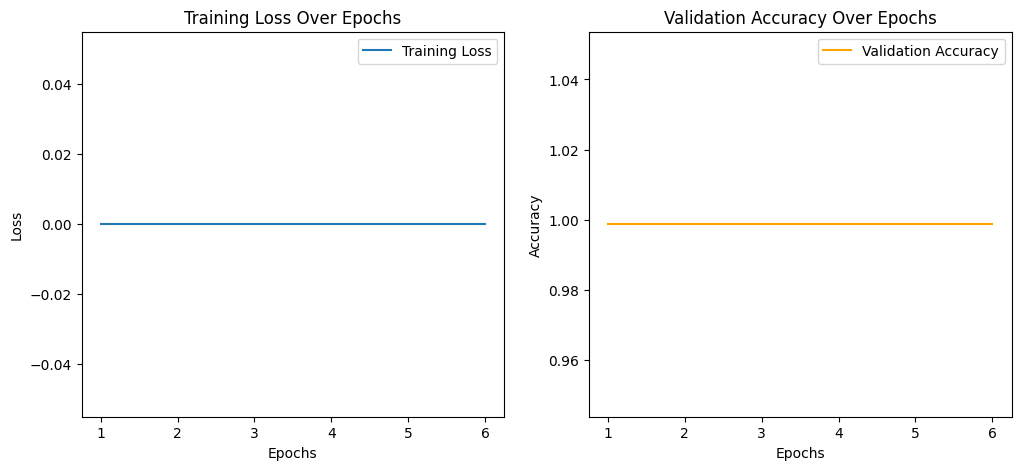

Final Test Accuracy: 0.9987


In [6]:
import matplotlib.pyplot as plt

# Define the optimizer with optimized learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_hyperparameters['lr'])

# Lists to store loss and accuracy values
train_losses = []
test_accuracies = []

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_accuracy = 0
epochs_no_improve = 0

# Train the model with optimized hyperparameters
num_epochs = 20  # Increase epochs for final training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.4f}')

    # Check for early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping on epoch {epoch+1}')
        break

# Plot the training loss and validation accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()

# Final Test Accuracy
print(f'Final Test Accuracy: {best_accuracy:.4f}')


In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Lists to store predictions and labels for computing F1 score, precision, and recall
all_predictions = []
all_labels = []

for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    all_predictions.extend(predicted.tolist())
    all_labels.extend(labels.tolist())

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.9987
Recall: 0.9987
F1 Score: 0.9987
